In [1]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor
%matplotlib inline

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp', 'sf']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
sf = hybrid.sf.to_numpy().reshape((-1,) + hybrid.sf.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp, sf), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 10
fh = 3

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [6]:
X.shape, y.shape

((220, 10, 25, 45, 7), (220, 3, 25, 45, 7))

<=== linear ===>
RMSE t2m: 3.158; R2 t2m: 0.295
RMSE sp: 1.096; R2 sp: 0.997
RMSE tcc: 0.46; R2 tcc: -1.552
RMSE u10: 1.209; R2 u10: 0.833
RMSE v10: 1.161; R2 v10: -0.403
RMSE tp: 0.027; R2 tp: -362908.498
RMSE sf: 0.027; R2 sf: 0.0


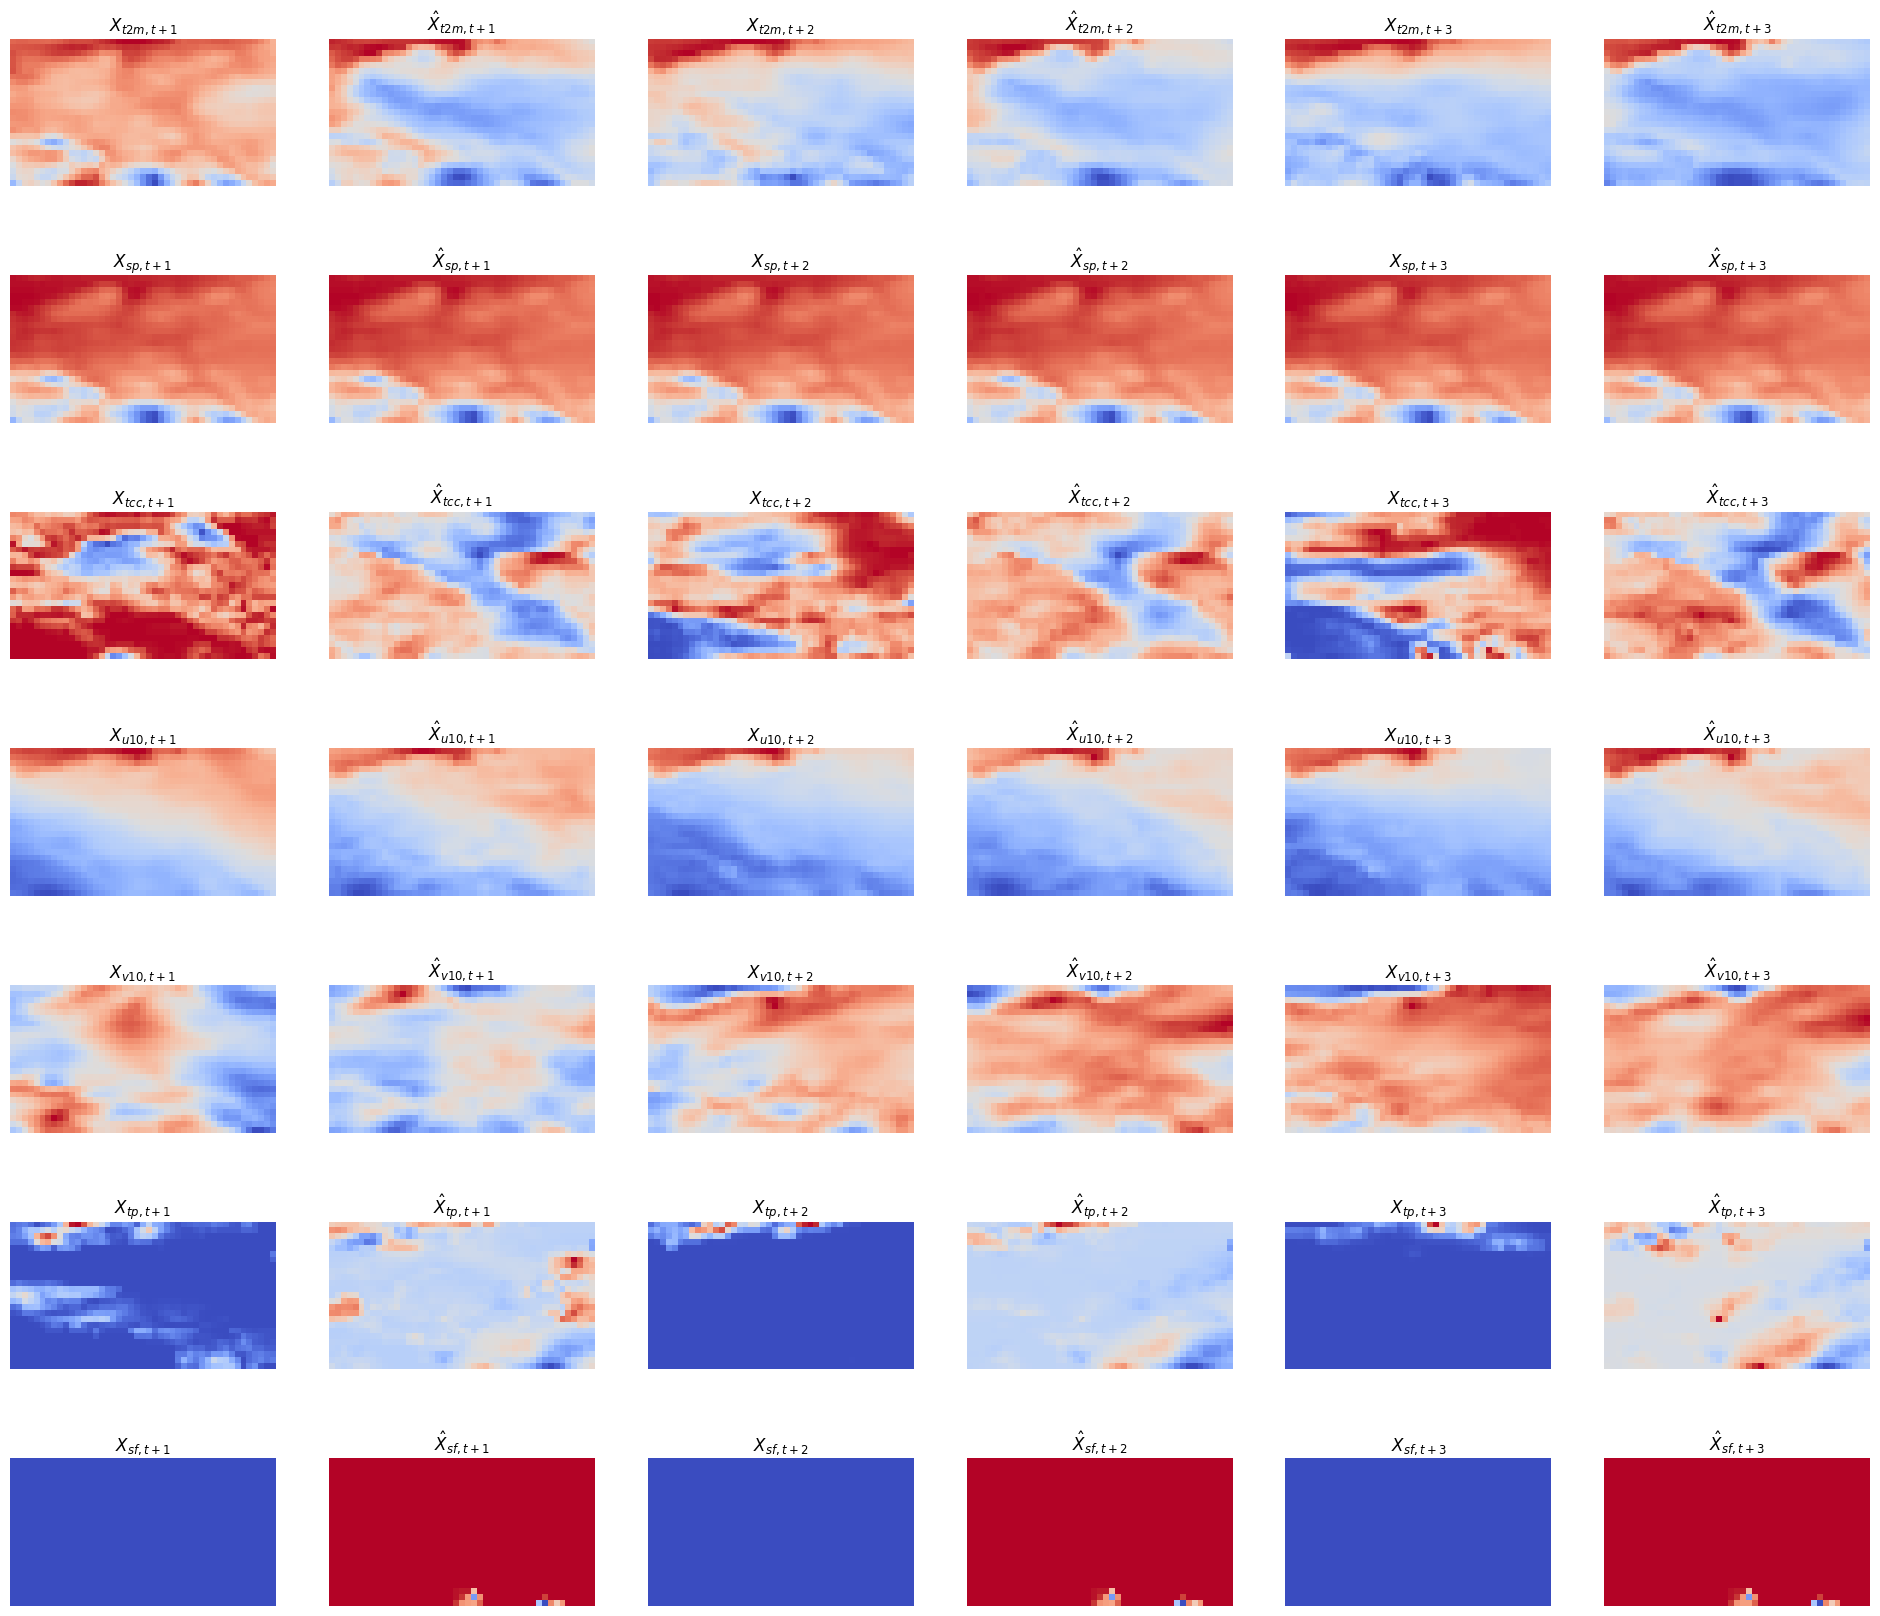

RMSE t2m: 4.271; R2 t2m: -0.67
RMSE sp: 2.259; R2 sp: 0.986
RMSE tcc: 0.391; R2 tcc: -0.606
RMSE u10: 0.908; R2 u10: 0.905
RMSE v10: 1.505; R2 v10: -0.717
RMSE tp: 0.027; R2 tp: -32654.91
RMSE sf: 0.027; R2 sf: 0.0


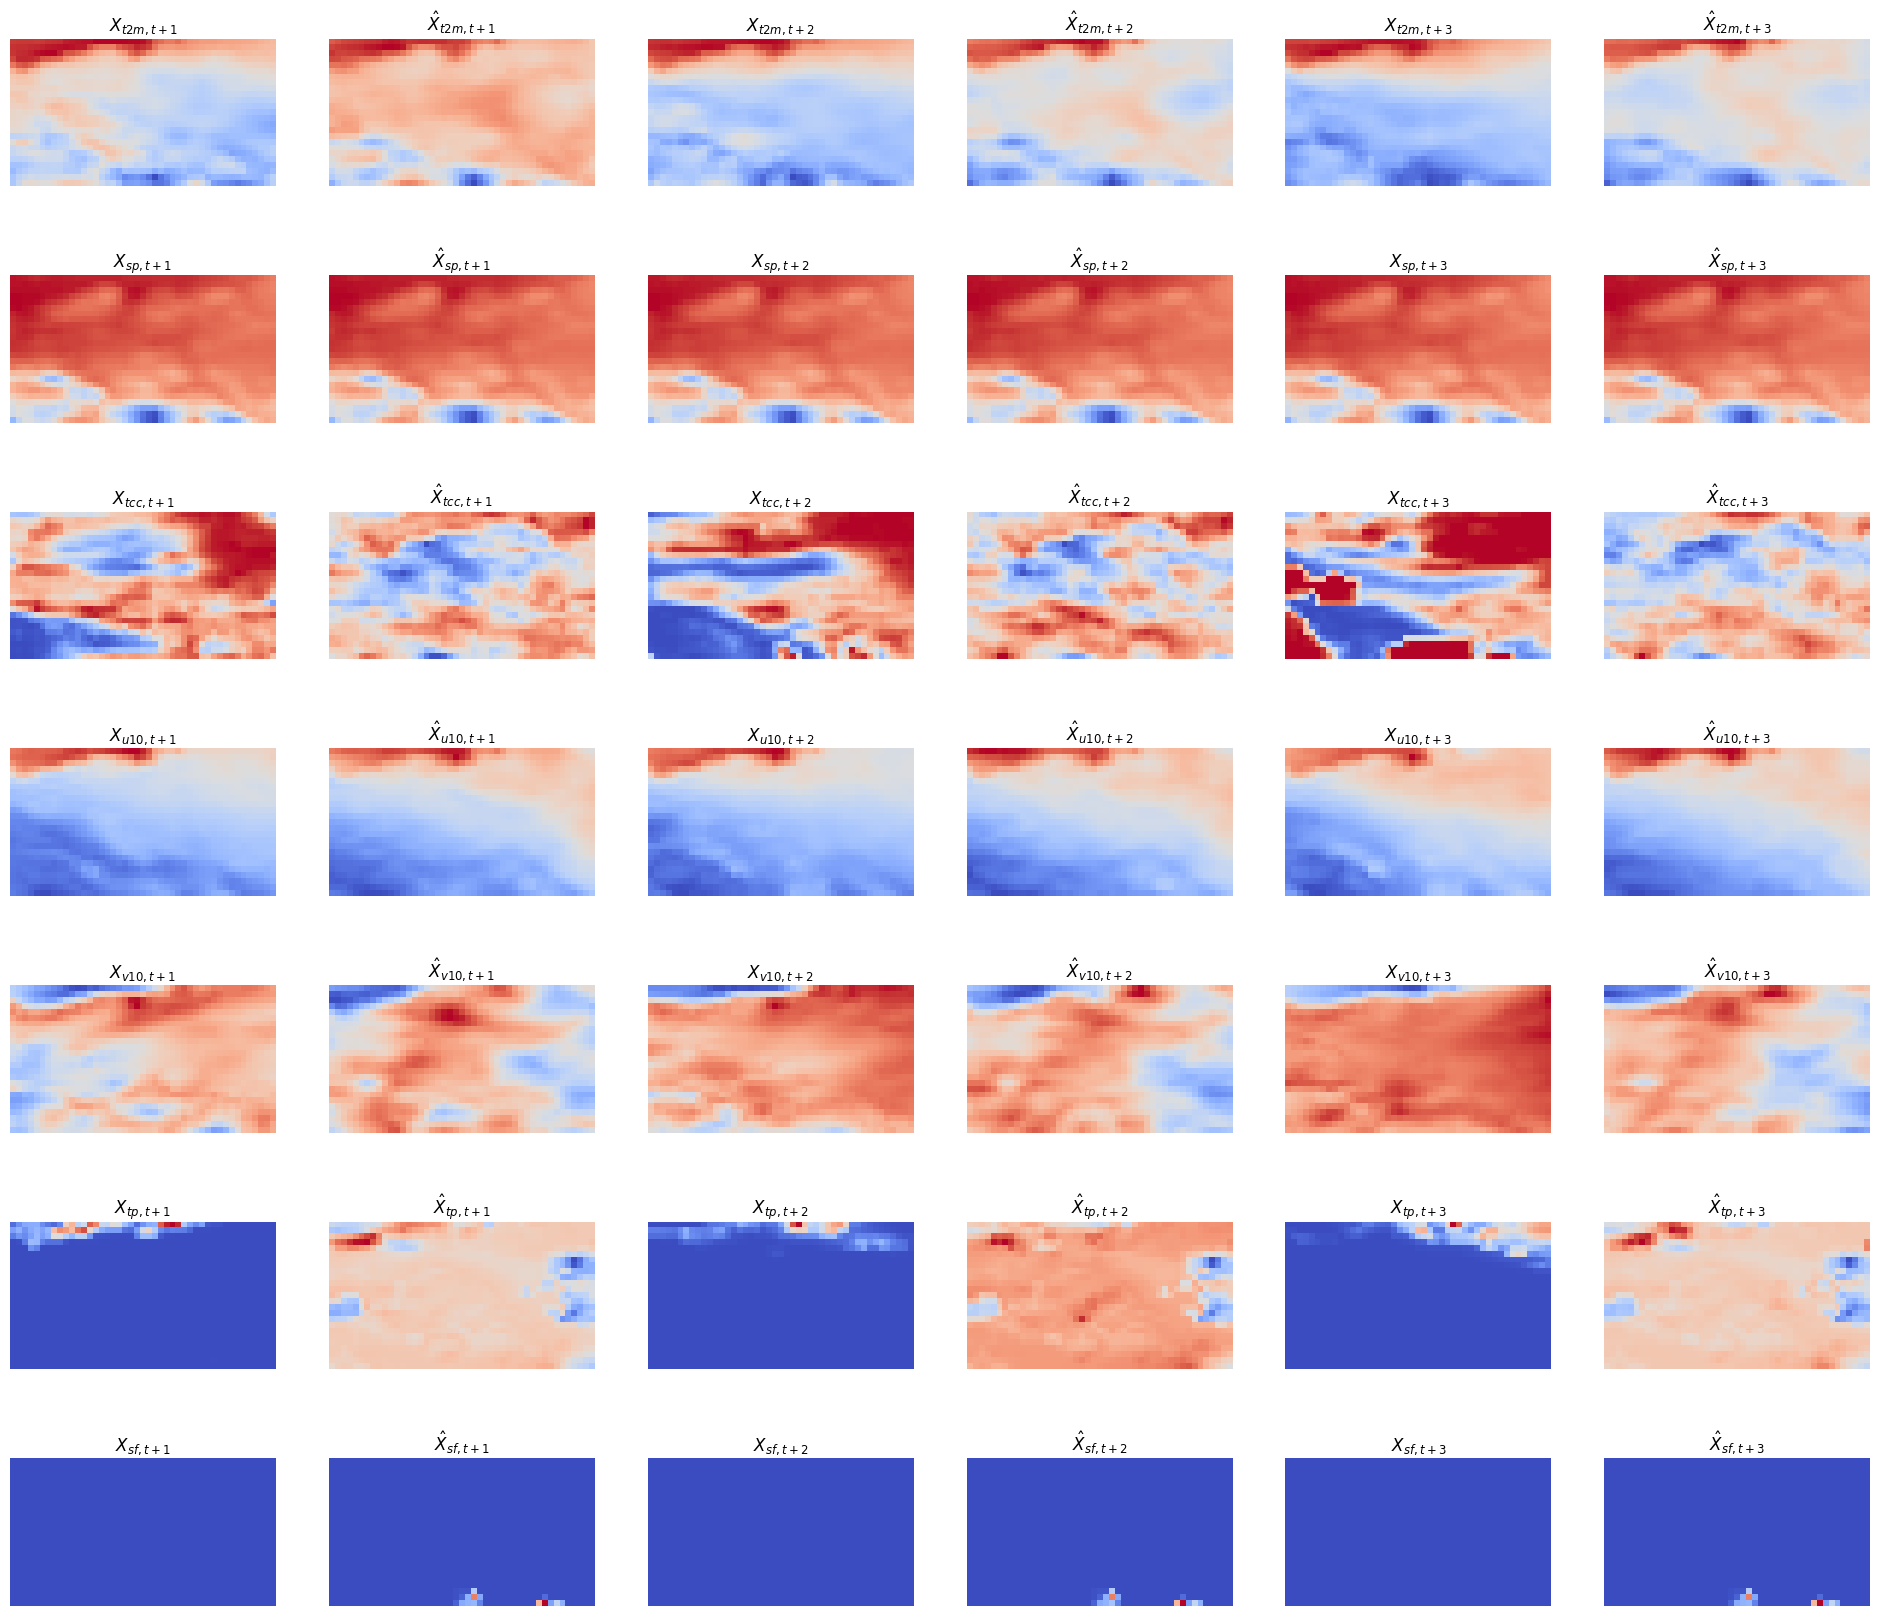

RMSE t2m: 2.25; R2 t2m: 0.777
RMSE sp: 2.694; R2 sp: 0.98
RMSE tcc: 0.439; R2 tcc: -0.732
RMSE u10: 1.572; R2 u10: 0.704
RMSE v10: 1.488; R2 v10: 0.077
RMSE tp: 0.027; R2 tp: -27242.723
RMSE sf: 0.027; R2 sf: 0.0


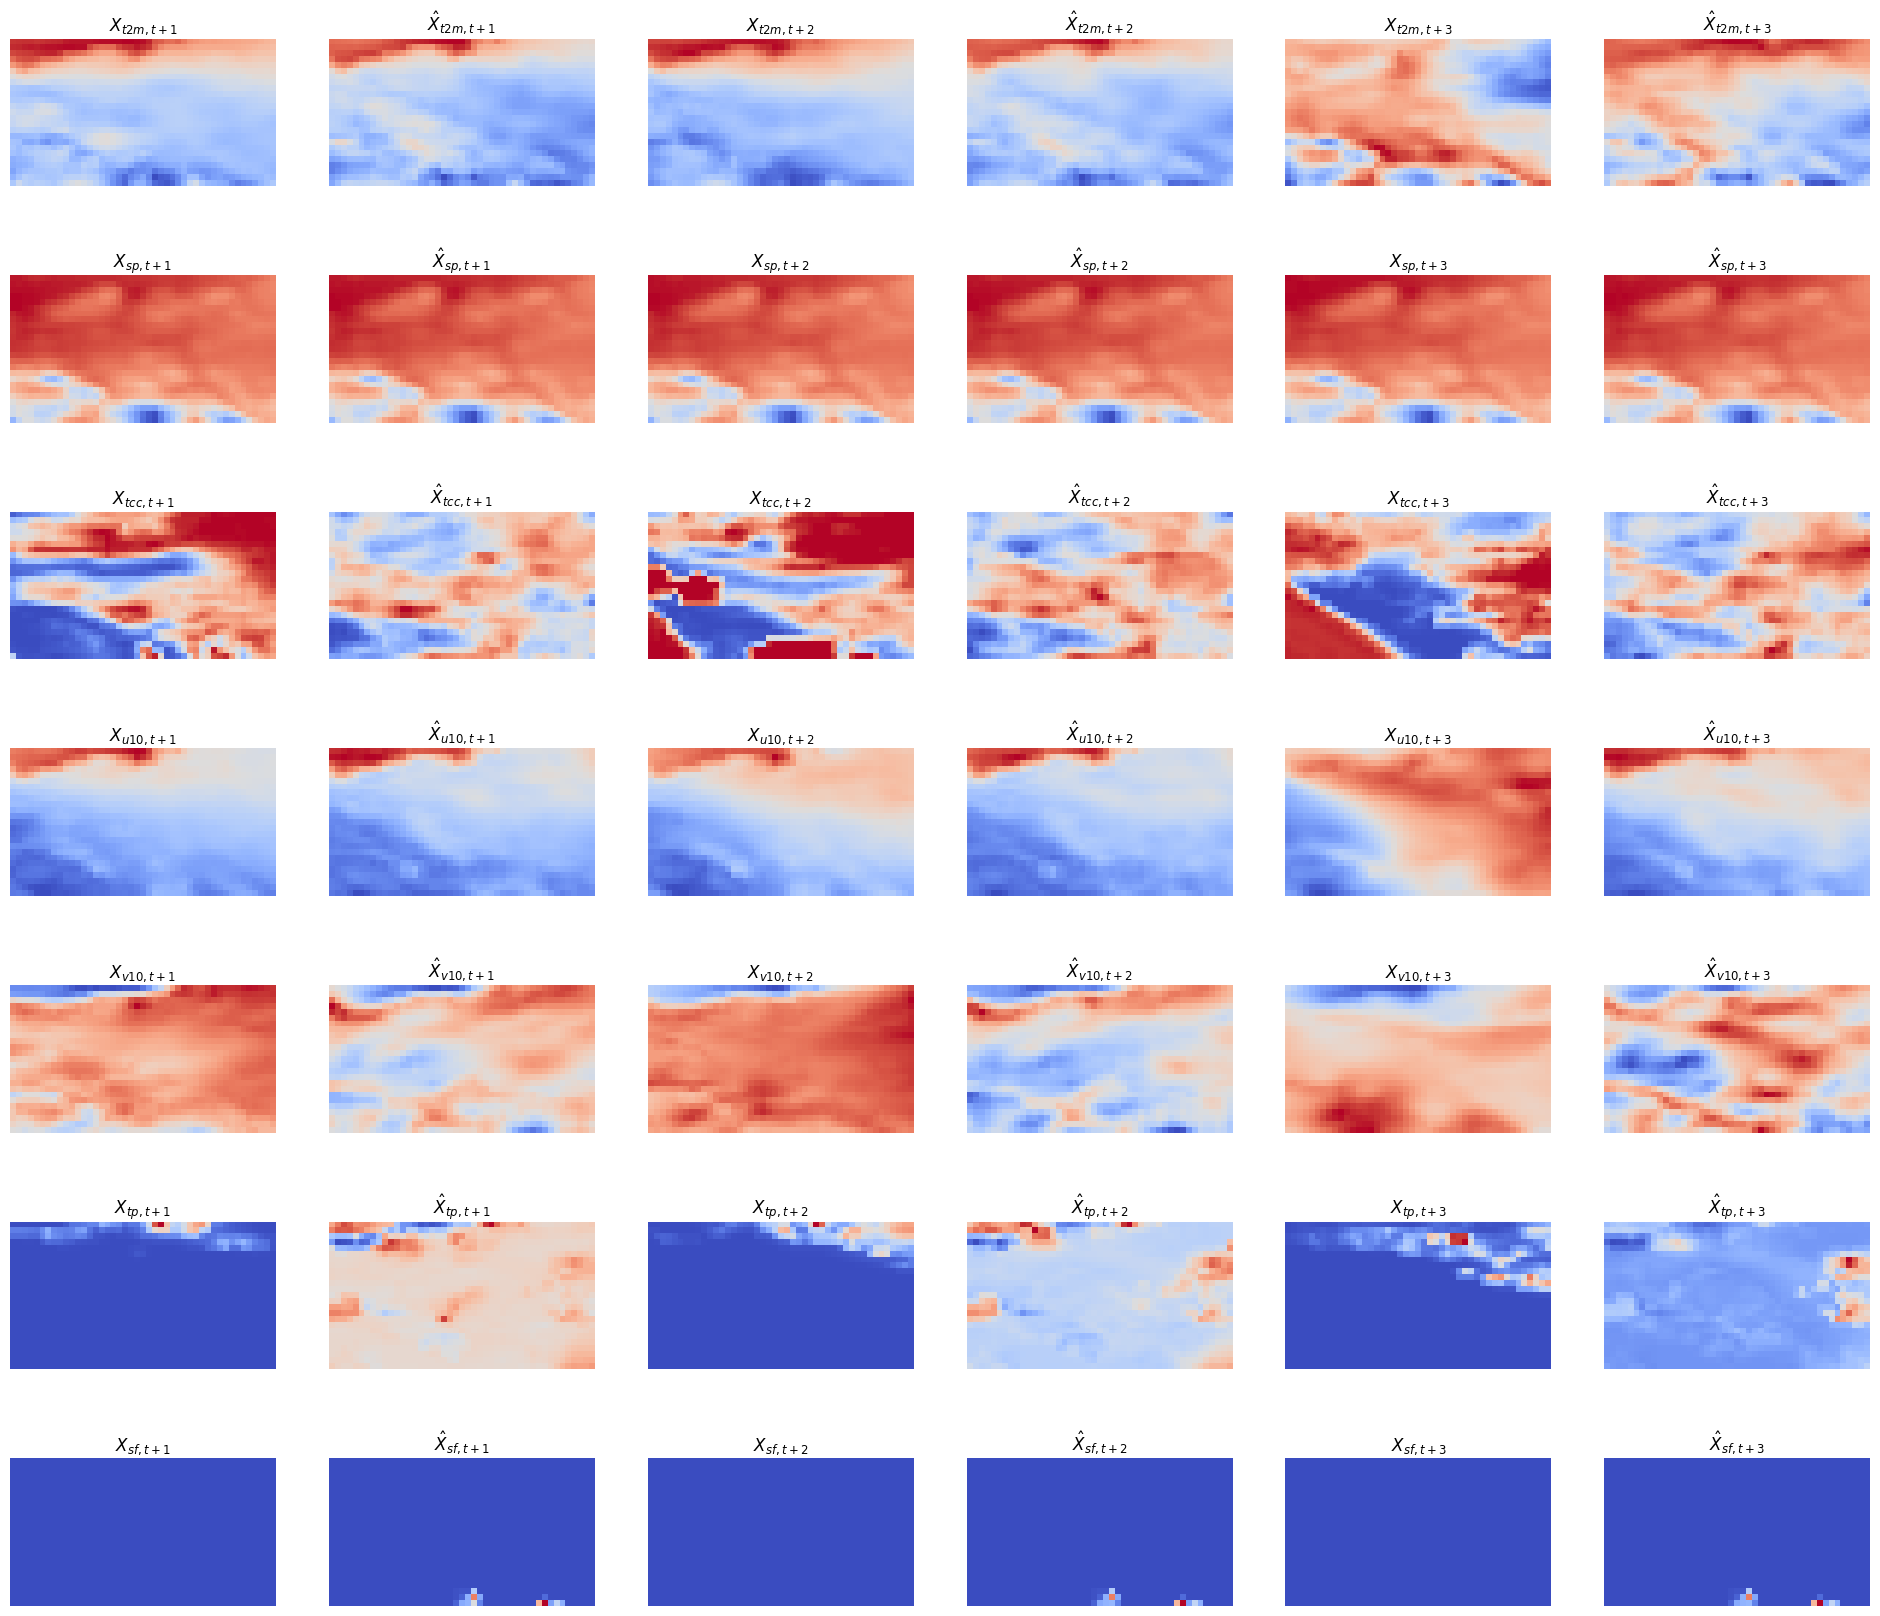

Evaluation metrics for entire test set:
RMSE t2m: 2.9534717648690223; R2 t2m: 0.4681688653228011
RMSE sp: 5.024899038058535; R2 sp: 0.941901272349743
RMSE tcc: 0.3609527136022827; R2 tcc: -0.4578090022113288
RMSE u10: 3.3683454142011793; R2 u10: 0.10131560625823177
RMSE v10: 1.850403634778157; R2 v10: -0.005558106082899306
RMSE tp: 0.02720724416883286; R2 tp: -5.9894906039739855
RMSE sf: 0.027191222370898438; R2 sf: -6.00113435593852






In [7]:
available_regressors = ["linear"] # "ridge", "lasso", "elastic_net"

for reg in available_regressors:
    print(f'<=== {reg} ===>')
    linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, limit=3)
    print('\n\n\n')